**Important Disclaimer:** Mockup. So far, the example here does not support
fit or predict, let alone hyperparameter tuning etc.

The pipeline shown here assumes the example input tables from
<a href="https://arxiv.org/pdf/1706.00327.pdf#page=3">Fig. 2</a>
of the following paper:
Hoang Thanh Lam, Johann-Michael Thiebaut, Mathieu Sinn, Bei Chen, Tiep Mai, and Oznur Alkan.
"One button machine for automating feature engineering in relational databases". 2017. 
https://arxiv.org/abs/1706.00327

In [1]:
from lale.expressions import it, Sum, DistinctCount

In [2]:
from lale.lib.lale import Scan, Join, GroupBy, Aggregate, ConcatFeatures
from lale.lib.lale import IdentityWrapper as Relational #hack!!
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from xgboost import XGBClassifier as XGBoost
import lale
lale.wrap_imported_operators()

In [3]:
# one-to-one path doesn't need GroupBy >> Aggregate
info_features = (
       (Scan(table=it.main) & Scan(table=it.info))
    >> Join(pred=it.main.TrainId == it.info.Train_Id)) #note the underscore
# one-to-many path (multiple delay rows per main-table row)
delay_features = (
       (Scan(table=it.main) & Scan(table=it.delay))
    >> Join() #natural join, since exactly one column name in common
    >> GroupBy(key=it.MessageId) #primary key of main table
    >> Aggregate(Delay=Sum(it.Delay)))
# multi-hop one-to-many path uses multi-way join
event_features = (
       (Scan(table=it.main) & Scan(table=it.delay) & Scan(table=it.event))
    >> Join(pred=[it.main.TrainId==it.delay.TrainId,
                  it.delay.StationId==it.event.StationId])
    >> GroupBy(key=it.MessageId) #primary key of main table
    >> Aggregate(EventCount=DistinctCount(it.Event)))

In [4]:
all_features = Relational(op=
       (info_features & delay_features & event_features)
    >> ConcatFeatures)
classifier = LR | KNN | XGBoost
pipeline = all_features >> OneHotEncoder() >> SelectKBest >> classifier

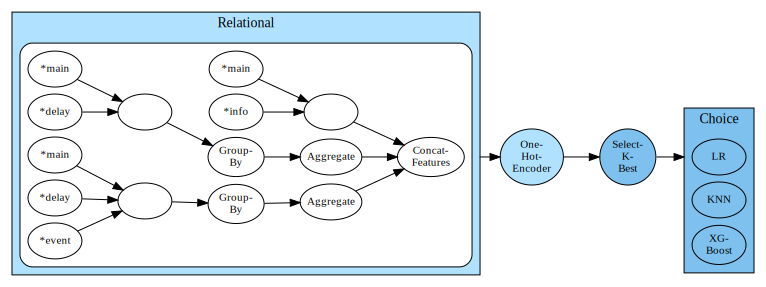

In [5]:
pipeline.visualize()

In [6]:
pipeline.pretty_print(show_imports=False, ipython_display=True)

```python
scan = Scan(table=it.main)
scan_0 = Scan(table=it.info)
join = Join(pred=(it.main.TrainId == it.info.Train_Id))
scan_1 = Scan(table=it.main)
scan_2 = Scan(table=it.delay)
group_by = GroupBy(key=it.MessageId)
aggregate = Aggregate(Delay=Sum(it.Delay))
scan_3 = Scan(table=it.main)
scan_4 = Scan(table=it.delay)
scan_5 = Scan(table=it.event)
join_1 = Join(pred=[(it.main.TrainId == it.delay.TrainId), (it.delay.StationId == it.event.StationId)])
group_by_0 = GroupBy(key=it.MessageId)
aggregate_0 = Aggregate(EventCount=DistinctCount(it.Event))
relational = Relational(op=(((scan & scan_0) >> join) & ((scan_1 & scan_2) >> Join() >> group_by >> aggregate) & ((scan_3 & scan_4 & scan_5) >> join_1 >> group_by_0 >> aggregate_0)) >> ConcatFeatures)
pipeline = relational >> OneHotEncoder() >> SelectKBest >> (LR | KNN | XGBoost)
```